# 🔍 SECOM 異常分數分析（Isolation Forest + AutoEncoder + SHAP）

本 Notebook 不直接進行分類，而是計算異常機率 / 分數，並透過 SHAP 解釋模型為何判定為異常。

## ✅ 分析內容：
- 使用 `IsolationForest` 與 `AutoEncoder` 輸出異常分數
- 排名 Top-K 異常樣本並分析異常成因
- 結合 SHAP 做模型解釋，幫助分析異常來源


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# 載入原始資料
raw_data = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom.data', delim_whitespace=True, header=None)
labels = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom_labels.data', delim_whitespace=True, header=None)
raw_data.columns = [f"sensor_{i+1}" for i in range(raw_data.shape[1])]
X = raw_data.copy()
y = (labels[0] == 1).astype(int)

# 資料切分
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent.parent  # 根據你的資料夾結構調整
print(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))
from preprocessing.secom_preprocessor import Preprocessor
from preprocessing.balancer import apply_smoteenn
pre = Preprocessor()
X_train_proc = pre.fit_transform(X_train)
X_test_proc = pre.transform(X_test)
X_train_proc,y_train = apply_smoteenn(X_train_proc, y_train, random_state=42)




/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_29055/1223925172.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_data = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom.data', delim_whitespace=True, header=None)
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_29055/1223925172.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv('/Users/ching/Documents/SideProject/data/secom/secom_labels.data', delim_whitespace=True, header=None)


/Users/ching/Documents/SideProject/industrial-fault-prediction
▶ Imputing missing values with mean...
▶ Handling outliers using IQR clipping...
▶ Removing near-zero variance features...
✅ Remaining features after variance filter: 590
▶ Removing highly correlated features (Pearson > 0.95)...
✅ Remaining features after correlation filter: 590
▶ Scaling features...


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7341.166315500787277 > -7353.966199808467536). You may want to try with a higher value of support_fraction (current value: 0.607).
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7234.690278157220746 > -7276.218146545667878). You may want to try with a higher value of support_fraction (current value: 0.607).
  warnings.warn(
/Users/

📊 ROC AUC Scores:
          ROC AUC
OCSVM       0.601
IF          0.547
Elliptic    0.440
LOF         0.418


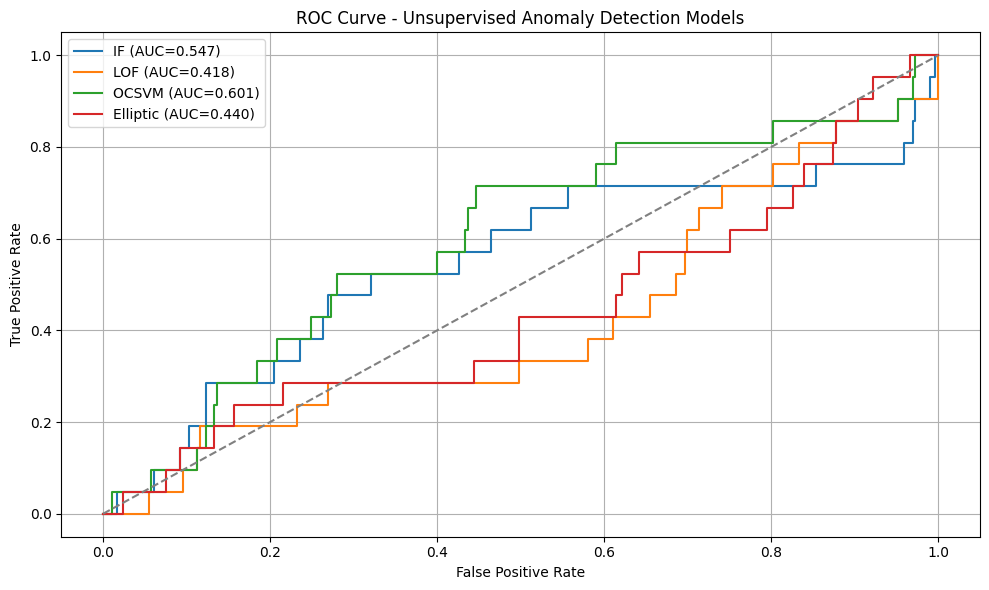


📁 預測分數已儲存為 'unsupervised_anomaly_scores.csv'
      true_label  IF_score  LOF_score  OCSVM_score  Elliptic_score
246            0  0.628004   0.625166     0.541190        0.063232
1315           0  0.329159   0.131710     0.409129        0.066290
444            0  0.681641   0.052854     0.726142        0.674110
296            0  0.605742   0.089935     0.699768        0.110499
1295           0  0.260827   0.315971     0.481210        0.265927


In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 假設你已定義：
# X_train_proc, X_test_proc, y_test

# 訓練模型
iso = IsolationForest(contamination=0.1, random_state=42).fit(X_train_proc)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True).fit(X_train_proc)
ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale').fit(X_train_proc)
elliptic = EllipticEnvelope(contamination=0.1, random_state=42).fit(X_train_proc)

# decision_function 分數（越小越異常 → 取負）
scores = {
    "IF": -iso.decision_function(X_test_proc),
    "LOF": -lof.decision_function(X_test_proc),
    "OCSVM": -ocsvm.decision_function(X_test_proc),
    "Elliptic": -elliptic.decision_function(X_test_proc),
}

# 標準化分數（0～1）
scaler = MinMaxScaler()
for k in scores:
    scores[k] = scaler.fit_transform(scores[k].reshape(-1, 1)).flatten()

# 計算 ROC AUC
auc_results = {}
for k in scores:
    auc_results[k] = roc_auc_score(y_test, scores[k])

# 顯示 AUC 表格
df_auc = pd.DataFrame.from_dict(auc_results, orient="index", columns=["ROC AUC"]).sort_values("ROC AUC", ascending=False)
print("📊 ROC AUC Scores:")
print(df_auc.round(3))

# 繪製 ROC 曲線
plt.figure(figsize=(10, 6))
for name, score in scores.items():
    fpr, tpr, _ = roc_curve(y_test, score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_results[name]:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Unsupervised Anomaly Detection Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 儲存所有分數 + 真實標籤為 DataFrame
df_scores = pd.DataFrame({"true_label": y_test})
for name, score in scores.items():
    df_scores[name + "_score"] = score

# 儲存為 CSV
df_scores.to_csv("unsupervised_anomaly_scores.csv", index=False)
print("\n📁 預測分數已儲存為 'unsupervised_anomaly_scores.csv'")
print(df_scores.head())

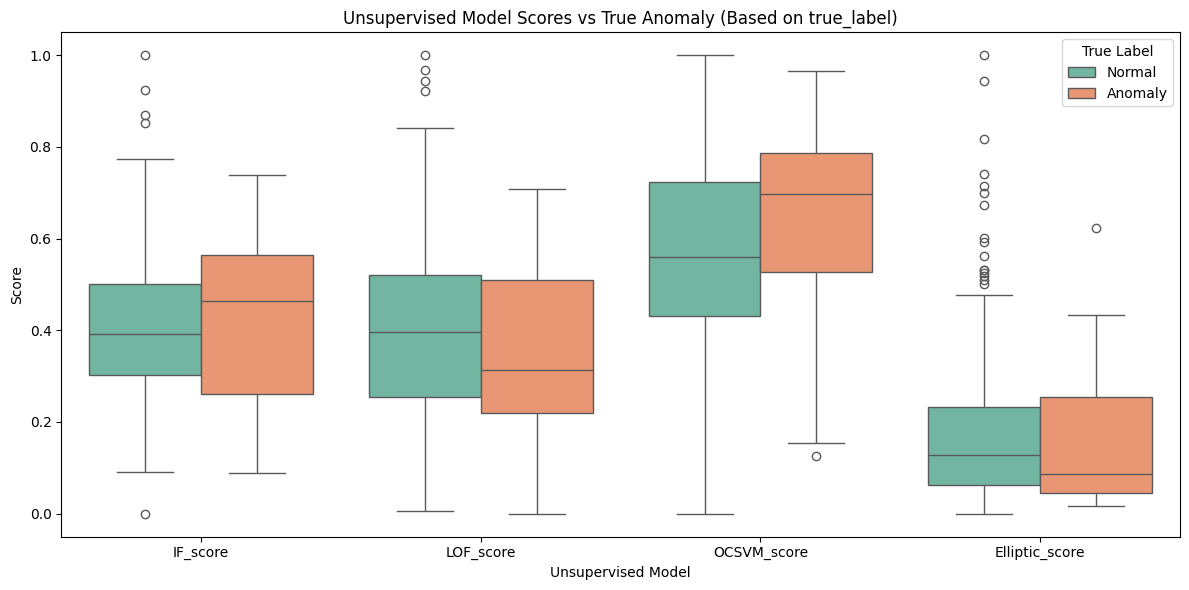

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取你的資料
unsup_df = df_scores.copy() # pd.read_csv("unsupervised_anomaly_scores.csv")

# 自動抓取包含 'score' 的欄位（排除 hybrid_score）
score_cols = [col for col in unsup_df.columns if "score" in col and "hybrid" not in col]

# melt 成繪圖格式
melted_unsup = unsup_df.melt(id_vars=["true_label"], value_vars=score_cols,
                             var_name="Model", value_name="Score")

# 將 true_label 轉為文字標籤（方便圖示）
melted_unsup["true_label"] = melted_unsup["true_label"].map({0: "Normal", 1: "Anomaly"})

# 繪製 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_unsup, x="Model", y="Score", hue="true_label", palette="Set2")
plt.title("Unsupervised Model Scores vs True Anomaly (Based on true_label)")
plt.xlabel("Unsupervised Model")
plt.ylabel("Score")
plt.legend(title="True Label")
plt.tight_layout()
plt.show()



📊 圖中顯示了 4 個模型的異常分數分布：
	•	IF_score（Isolation Forest）
	•	LOF_score（Local Outlier Factor）
	•	OCSVM_score（One-Class SVM）
	•	Elliptic_score（Elliptic Envelope）

每個模型對於：
	•	Normal（正常樣本）與
	•	Anomaly（異常樣本）

的分數分布情形。

⸻

✅ 各模型解釋與評估

1️⃣ IF_score（Isolation Forest）
	•	異常樣本的分數中位數略高，但 overlap 較大
	•	→ ⚠️ 區分能力中等，但 FP 多（正常樣本也常被判高分）

⸻

2️⃣ LOF_score（Local Outlier Factor）
	•	異常與正常的中位數差距很小，分布重疊
	•	→ ⚠️ 區分能力差，幾乎無法辨識異常

⸻

3️⃣ OCSVM_score
	•	異常的中位數高於正常，而且分布往上偏
	•	→ ✅ 區分能力不錯，適合納入 hybrid vote 或 threshold 判斷

⸻

4️⃣ Elliptic_score
	•	異常與正常皆集中於低分區域
	•	分佈差異很小，且整體分數低
	•	→ ⚠️ 不建議納入異常判斷模型中（訊號弱）

⸻

🧠 結論：推薦動作

模型	建議動作
OCSVM_score	✅ 納入 Hybrid Score / 投票
IF_score	⚠️ 可納入但設高 threshold
LOF_score	❌ 排除，區分力太差
Elliptic_score	❌ 排除，不具識別性


⸻

🎯 建議的下一步

你可以依照此圖：
	•	更新 hybrid_score 加權策略（例如 OCSVM 佔比 0.5，IF 0.5）
	•	移除 LOF 與 Elliptic 避免稀釋信號
	•	在 Potential Risk 判斷上使用 OCSVM + model score 組合策略

要我幫你重建一個「最佳權重 + 三層風險策略」的程式碼嗎？只要你說「要重建 Hybrid 策略」我就立刻處理。

In [28]:
# 修改 evaluate_custom_hybrid_strategy：支援三層風險標籤與風險區間劃分
def evaluate_custom_hybrid_strategy(df, score_cols, weights, label_col="true_label",
                                    plot=True, risk_thresholds=(0.4, 0.7)):
    assert len(score_cols) == len(weights), "分數欄位與權重數量需一致"
    df = df.copy()

    # 計算 hybrid 分數
    df["hybrid_score"] = sum(df[col] * w for col, w in zip(score_cols, weights))

    # 自動尋找最佳 Threshold（for binary F1）
    precision, recall, thresholds = precision_recall_curve(df[label_col], df["hybrid_score"])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    f1_scores = f1_scores[:-1]
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]

    # 加入預測欄位（binary）
    df["pred_is_anomaly"] = df["hybrid_score"] > best_thresh

    # 加入三層風險分類
    low, high = risk_thresholds
    def classify_risk(score):
        if score >= high:
            return "High Risk"
        elif score >= low:
            return "Potential Risk"
        else:
            return "Normal"
    df["risk_level"] = df["hybrid_score"].apply(classify_risk)

    # 效能報告（binary）
    report = classification_report(df[label_col], df["pred_is_anomaly"], output_dict=True)
    conf_matrix = confusion_matrix(df[label_col], df["pred_is_anomaly"])
    df_report = pd.DataFrame(report).T.round(3)

    if plot:
        # F1-score vs Threshold 曲線
        plt.figure(figsize=(8, 4))
        plt.plot(thresholds, f1_scores, color="orange", label="F1-score")
        plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best Threshold = {best_thresh:.3f}")
        plt.xlabel("Threshold")
        plt.ylabel("F1-score")
        plt.title("F1-score vs Hybrid Threshold")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 混淆矩陣圖
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
                    xticklabels=["Normal", "Anomaly"],
                    yticklabels=["Actual Normal", "Actual Anomaly"])
        plt.title(f"Confusion Matrix (Threshold = {best_thresh:.3f})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

    return df, best_thresh, df_report

# ✅ 使用方式：
# df_result, threshold, report_df = evaluate_custom_hybrid_strategy(
#     df_scores,
#     score_cols=["IF_score", "LOF_score", "OCSVM_score", "Elliptic_score"],
#     weights=[0.4, 0.2, 0.2, 0.2],
#     risk_thresholds=(0.4, 0.7)
# )


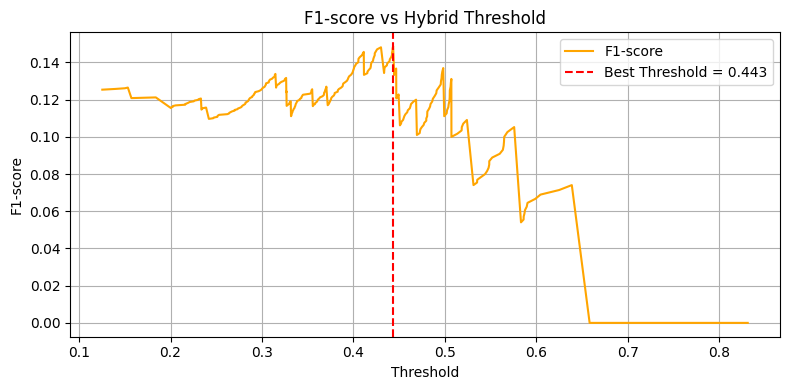

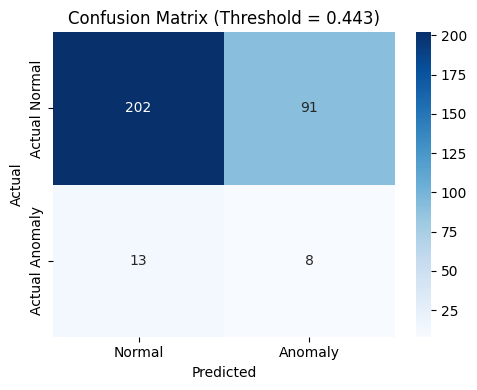

In [29]:
df_result, threshold, report_df = evaluate_custom_hybrid_strategy(
    df_scores,
    score_cols=["IF_score", "LOF_score", "OCSVM_score", "Elliptic_score"],
    weights=[0.4, 0.2, 0.2, 0.2],
    risk_thresholds=(0.4, 0.7)
)

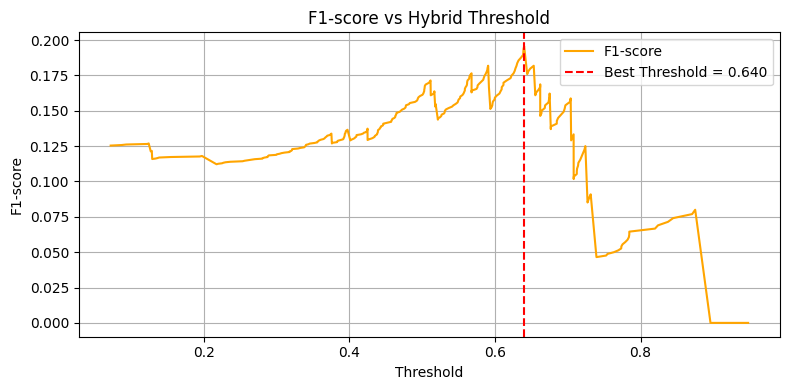

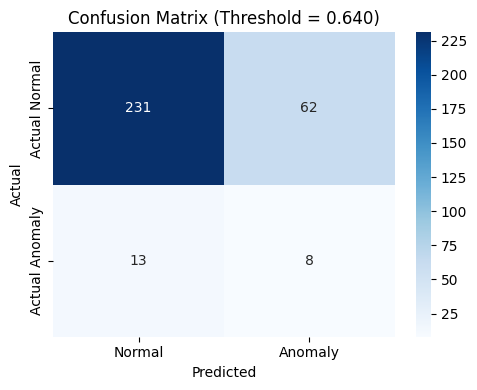

In [30]:
df_result, threshold, report_df = evaluate_custom_hybrid_strategy(
    df_scores,
    score_cols=["IF_score", "LOF_score", "OCSVM_score", "Elliptic_score"],
    weights=[0.4, 0, 0.6, 0],
    risk_thresholds=(0.4, 0.7)
)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


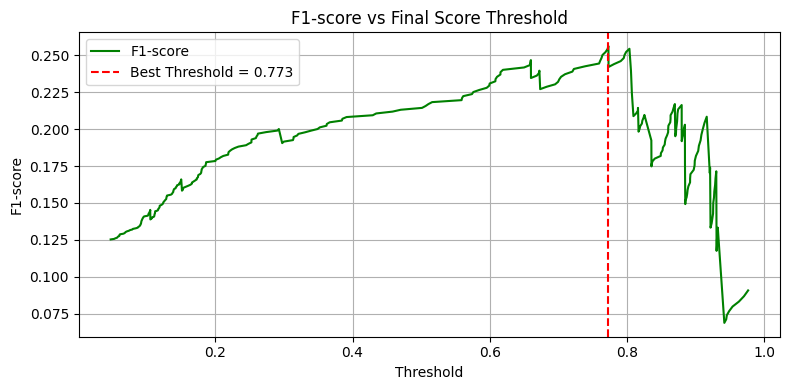

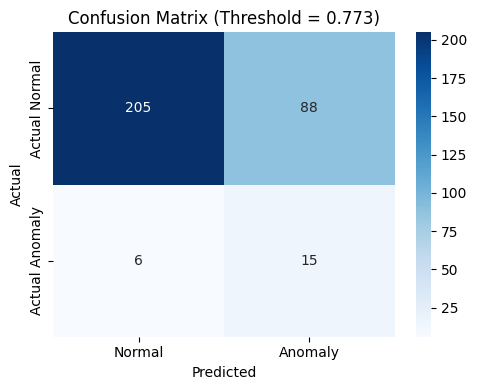

✅ Best Threshold = 0.773


,precision,recall,f1-score,support
0,0.972,0.700,0.813,293.000
1,0.146,0.714,0.242,21.000
accuracy,0.701,0.701,0.701,0.701
macro avg,0.559,0.707,0.528,314.000
weighted avg,0.916,0.701,0.775,314.000


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split


# 🔹 Stage 1 — LightGBM 主模型
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_train_proc,y_train)
df_scores["lgbm_score"] = lgbm.predict_proba(X_test_proc)[:, 1]

# 🔸 Stage 2 — Hybrid 分數結合（依據先前 boxplot 結論）
df_scores["hybrid_score"] = (
    df_scores["OCSVM_score"] * 0.7 +
    df_scores["IF_score"] * 0.3
)

# 🎯 Stage 3 — 組合策略判斷
# ➤ 整合分數（可調整權重）
df_scores["final_score"] = (
    df_scores["lgbm_score"] * 0.8 +
    df_scores["hybrid_score"] * 0.2
)

# ➤ 自動搜尋最佳 threshold（以 F1-score 最佳為準）
precision, recall, thresholds = precision_recall_curve(df_scores.loc[X_test.index, "true_label"], df_scores.loc[X_test.index, "final_score"])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
f1_scores = f1_scores[:-1]  
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
# best_thresh = 0.5

# ➤ 最終預測
df_scores["final_pred"] = df_scores["final_score"] > best_thresh

# 🧾 評估報告與混淆矩陣
report = classification_report(df_scores.loc[X_test.index, "true_label"], df_scores.loc[X_test.index, "final_pred"], output_dict=True)
df_report = pd.DataFrame(report).T.round(3)
conf_matrix = confusion_matrix(df_scores.loc[X_test.index, "true_label"], df_scores.loc[X_test.index, "final_pred"])

# 📈 繪製 F1 分數對 Threshold 曲線
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, color="green", label="F1-score")
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best Threshold = {best_thresh:.3f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Final Score Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 混淆矩陣視覺化
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.3f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 🔎 顯示報告
print(f"✅ Best Threshold = {best_thresh:.3f}")
display(df_report)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


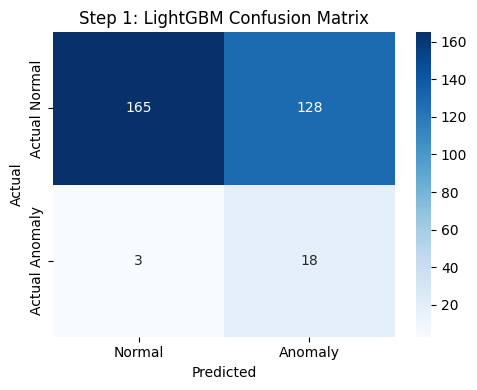

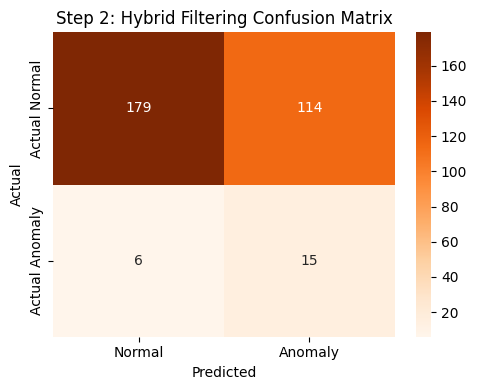

📋 Step 1 Report (LGBM):


,precision,recall,f1-score,support
0,0.982,0.563,0.716,293.000
1,0.123,0.857,0.216,21.000
accuracy,0.583,0.583,0.583,0.583
macro avg,0.553,0.710,0.466,314.000
weighted avg,0.925,0.583,0.682,314.000


📋 Step 2 Report (Hybrid Filter):


,precision,recall,f1-score,support
0,0.968,0.611,0.749,293.000
1,0.116,0.714,0.200,21.000
accuracy,0.618,0.618,0.618,0.618
macro avg,0.542,0.663,0.474,314.000
weighted avg,0.911,0.618,0.712,314.000


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 🧪 假設 X_train_proc, y_train, X_test_proc, y_test 已定義
# 🧪 假設 df_scores 已包含 unsupervised 分數欄位（如 OCSVM_score, IF_score）

# 🔹 Step 1 — LightGBM 主模型
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_train_proc, y_train)

# Step 1 預測分數與初步預測結果
df_scores["lgbm_score"] = lgbm.predict_proba(X_test_proc)[:, 1]
df_scores["lgbm_pred"] = (df_scores["lgbm_score"] > 0.5).astype(int)

# 📊 Step 1 評估結果
report1 = classification_report(y_test, df_scores["lgbm_pred"], output_dict=True)
conf_matrix1 = confusion_matrix(y_test, df_scores["lgbm_pred"])
df_report1 = pd.DataFrame(report1).T.round(3)

# 🔸 Step 2 — 針對 lgbm 預測為異常的樣本進行過濾
abnormal_idx = df_scores[df_scores["lgbm_pred"] == 1].index
df_scores["hybrid_score"] = (
    df_scores["OCSVM_score"] * 0.7 +
    df_scores["IF_score"] * 0.3
)
df_scores["final_pred"] = 0
df_scores.loc[abnormal_idx, "final_pred"] = (df_scores.loc[abnormal_idx, "hybrid_score"] > 0.3).astype(int)

# Step 2 評估報告與混淆矩陣
report2 = classification_report(y_test, df_scores["final_pred"], output_dict=True)
conf_matrix2 = confusion_matrix(y_test, df_scores["final_pred"])
df_report2 = pd.DataFrame(report2).T.round(3)

# ====== 視覺化 Step 1 混淆矩陣 ======
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Step 1: LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ====== 視覺化 Step 2 混淆矩陣 ======
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap="Oranges",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Step 2: Hybrid Filtering Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ 顯示報告
print("📋 Step 1 Report (LGBM):")
display(df_report1)

print("📋 Step 2 Report (Hybrid Filter):")
display(df_report2)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


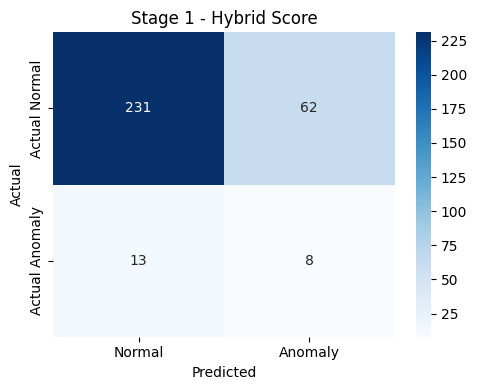

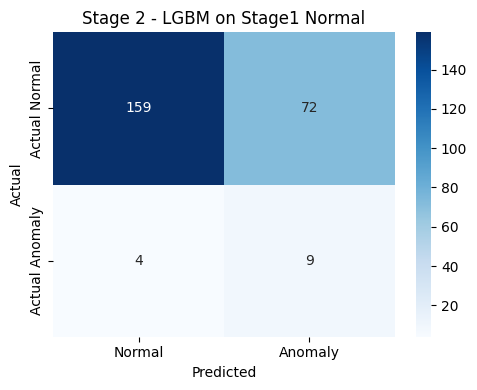

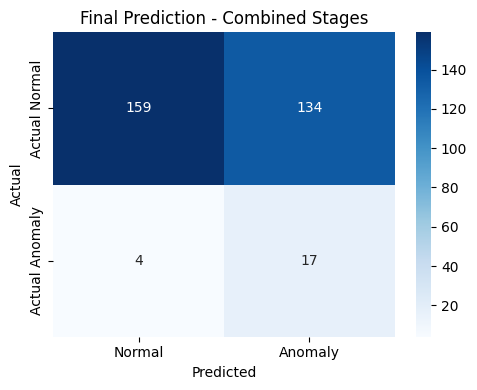

✅ Stage1 Thresh: 0.640, Stage2 Thresh: 0.833


,precision,recall,f1-score,support
0,0.975,0.543,0.697,293.000
1,0.113,0.810,0.198,21.000
accuracy,0.561,0.561,0.561,0.561
macro avg,0.544,0.676,0.448,314.000
weighted avg,0.918,0.561,0.664,314.000


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 假設你已經有以下變數：df_scores, X_train_proc, X_test_proc, y_train

# Step 1: Hybrid Score 分數（OCSVM + IF）
df = df_scores.copy()
df["stage1_score"] = df["OCSVM_score"] * 0.6 + df["IF_score"] * 0.4

# 找最佳 threshold
precision1, recall1, thresholds1 = precision_recall_curve(df["true_label"], df["stage1_score"])
f1_scores1 = 2 * (precision1 * recall1) / (precision1 + recall1 + 1e-6)
thresholds1 = thresholds1[:len(f1_scores1)]
best_thresh1 = thresholds1[np.argmax(f1_scores1)]

# Stage 1 預測
df["stage1_pred"] = df["stage1_score"] > best_thresh1

# Step 2: 用 LGBM 分析 Stage 1 判斷為「正常」的資料
mask_normal = ~df["stage1_pred"]
X_selected = X_test_proc[mask_normal]
y_selected = df.loc[mask_normal, "true_label"]

lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_train_proc, y_train)
stage2_score = lgbm.predict_proba(X_selected)[:, 1]

# 對 Stage 2 找出最佳 threshold
precision2, recall2, thresholds2 = precision_recall_curve(y_selected, stage2_score)
f1_scores2 = 2 * (precision2 * recall2) / (precision2 + recall2 + 1e-6)
thresholds2 = thresholds2[:len(f1_scores2)]
best_thresh2 = thresholds2[np.argmax(f1_scores2)]

df["stage2_pred"] = False
df.loc[mask_normal, "stage2_pred"] = stage2_score > best_thresh2

# 最終結果：Stage 1 or Stage 2 任一為 True 都標為異常
df["final_pred"] = df["stage1_pred"] | df["stage2_pred"]

# ===== 可視化 =====
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Normal", "Anomaly"],
                yticklabels=["Actual Normal", "Actual Anomaly"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# 混淆矩陣
plot_conf_matrix(df["true_label"], df["stage1_pred"], "Stage 1 - Hybrid Score")
plot_conf_matrix(df.loc[mask_normal, "true_label"], df.loc[mask_normal, "stage2_pred"], "Stage 2 - LGBM on Stage1 Normal")
plot_conf_matrix(df["true_label"], df["final_pred"], "Final Prediction - Combined Stages")

# 最終報告
report = classification_report(df["true_label"], df["final_pred"], output_dict=True)
df_report = pd.DataFrame(report).T.round(3)
print(f"✅ Stage1 Thresh: {best_thresh1:.3f}, Stage2 Thresh: {best_thresh2:.3f}")
display(df_report)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
📘 Strategy 1: Hybrid→LGBM Recall Boost
              precision    recall  f1-score   support

           0      1.000     0.263     0.416       293
           1      0.089     1.000     0.163        21

    accuracy                          0.312       314
   macro avg      0.544     0.631     0.290       314
weighted avg      0.939     0.312     0.399       314



/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


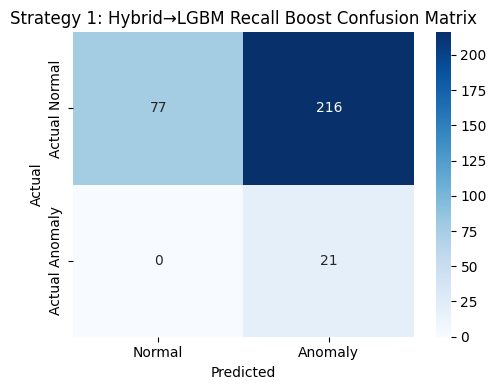

📘 Strategy 2: Confidence Filter
              precision    recall  f1-score   support

           0      0.967     0.601     0.741       293
           1      0.114     0.714     0.196        21

    accuracy                          0.608       314
   macro avg      0.540     0.657     0.469       314
weighted avg      0.910     0.608     0.705       314



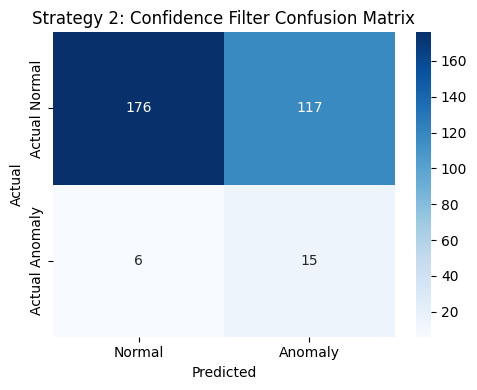

📘 Strategy 3: Voting
              precision    recall  f1-score   support

           0      0.971     0.573     0.721       293
           1      0.113     0.762     0.198        21

    accuracy                          0.586       314
   macro avg      0.542     0.668     0.459       314
weighted avg      0.914     0.586     0.686       314



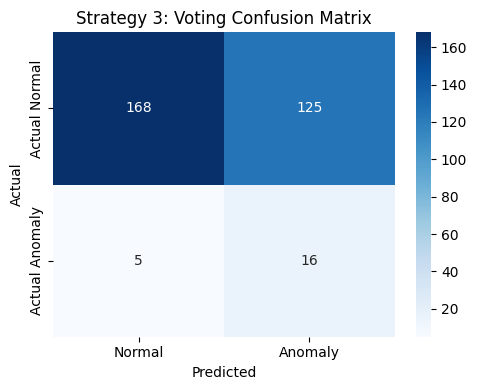

In [72]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 假設變數：df_scores, X_train_proc, y_train, X_test_proc 已準備好
df = df_scores.copy()

# 建立 Hybrid 分數（可依需要調整）
df["hybrid_score"] = df["OCSVM_score"] * 0.6 + df["IF_score"] * 0.4

# 訓練 LGBM 模型並預測 lgbm_score
lgbm_model = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_model.fit(X_train_proc, y_train)
df["lgbm_score"] = lgbm_model.predict_proba(X_test_proc)[:, 1]

# -------------------------------
# ✅ Strategy 1：Hybrid 判正常 → LGBM 補漏
# -------------------------------
df["stage1_pred"] = df["hybrid_score"] > 0.5
mask_stage1_normal = ~df["stage1_pred"]
df["stage2_pred"] = False
df.loc[mask_stage1_normal, "stage2_pred"] = df.loc[mask_stage1_normal, "lgbm_score"] > 0.5
df["final_pred_1"] = df["stage1_pred"] | df["stage2_pred"]

# -------------------------------
# ✅ Strategy 2：Confidence Filter（高 lgbm + 低 hybrid → 懷疑為 FP）
# -------------------------------
df["final_pred_2"] = df["lgbm_score"] > 0.5
mask_filter = (df["lgbm_score"] > 0.8) & (df["hybrid_score"] < 0.3)
df.loc[mask_filter, "final_pred_2"] = False

# -------------------------------
# ✅ Strategy 3：模型投票（3 者中 2 票判異常）
# -------------------------------
pred_lgbm = df["lgbm_score"] > 0.5
pred_ocsvm = df["OCSVM_score"] > 0.5
pred_if = df["IF_score"] > 0.5
votes = pred_lgbm.astype(int) + pred_ocsvm.astype(int) + pred_if.astype(int)
df["final_pred_3"] = votes >= 2

# -------------------------------
# 📊 統整三策略的報告
# -------------------------------
from sklearn.metrics import confusion_matrix

def evaluate_strategy(y_true, y_pred, name):
    print(f"📘 {name}")
    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Normal", "Anomaly"],
                yticklabels=["Actual Normal", "Actual Anomaly"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# 執行報告與可視化
evaluate_strategy(df["true_label"], df["final_pred_1"], "Strategy 1: Hybrid→LGBM Recall Boost")
evaluate_strategy(df["true_label"], df["final_pred_2"], "Strategy 2: Confidence Filter")
evaluate_strategy(df["true_label"], df["final_pred_3"], "Strategy 3: Voting")

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 936, number of negative: 111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70456
[LightGBM] [Info] Number of data points in the train set: 1047, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 936, number of negative: 111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70445
[LightGBM] [Info] Number of data points in the train set: 1047, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 936, number of negative: 111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70430
[LightGBM] [Info] Number of data points in the train set: 1047, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 936, number of negative: 111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70453
[LightGBM] [Info] Number of data points in the train set: 1047, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 936, number of negative: 112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70420
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.988259 -> initscore=4.432870
[LightGBM] [Info] Start training from score 4.432870
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model 1: Threshold = 0.826, F1 = 0.248, Precision = 0.148, Recall = 0.762
Model 2: Threshold = 0.976, F1 = 0.274, Precision = 0.192, Recall = 0.476
Model 3: Threshold = 1.000, F1 = 0.286, Precision = 0.229, Recall = 0.381


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


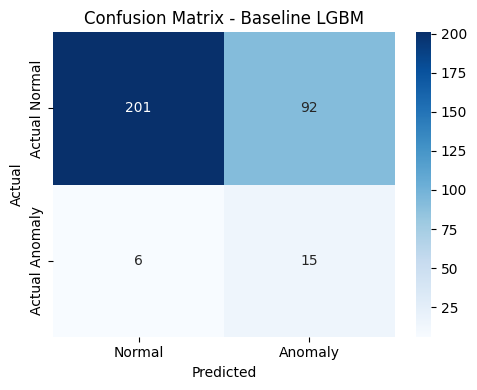

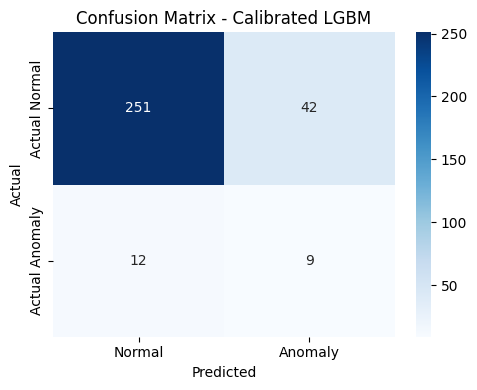

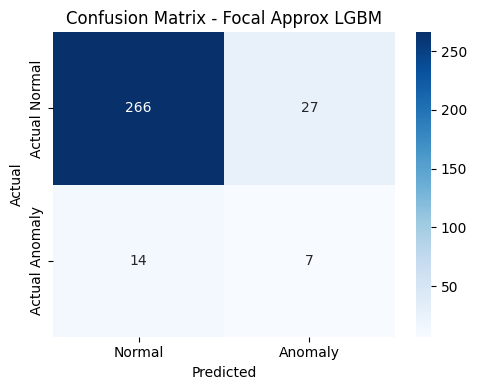


📋 Classification Report - Baseline:


,precision,recall,f1-score,support
0,0.971,0.686,0.804,293.000
1,0.140,0.714,0.234,21.000
accuracy,0.688,0.688,0.688,0.688
macro avg,0.556,0.700,0.519,314.000
weighted avg,0.915,0.688,0.766,314.000



📋 Classification Report - Calibrated:


,precision,recall,f1-score,support
0,0.954,0.857,0.903,293.000
1,0.176,0.429,0.250,21.000
accuracy,0.828,0.828,0.828,0.828
macro avg,0.565,0.643,0.576,314.000
weighted avg,0.902,0.828,0.859,314.000



📋 Classification Report - Focal Approx:


,precision,recall,f1-score,support
0,0.950,0.908,0.928,293.000
1,0.206,0.333,0.255,21.000
accuracy,0.869,0.869,0.869,0.869
macro avg,0.578,0.621,0.591,314.000
weighted avg,0.900,0.869,0.883,314.000


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

# 假設你已有 X_train_proc, y_train, X_test_proc, y_test, df_scores（含 true_label）

def evaluate_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx], precision[best_idx], recall[best_idx]

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal", "Anomaly"],
                yticklabels=["Actual Normal", "Actual Anomaly"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# -----------------------
# 🔹 Model 1: Baseline LGBM
# -----------------------
model1 = LGBMClassifier(class_weight='balanced', random_state=42)
model1.fit(X_train_proc, y_train)
score1 = model1.predict_proba(X_test_proc)[:, 1]
thresh1, f1_1, prec1, rec1 = evaluate_threshold(y_test, score1)
pred1 = score1 > thresh1
report1 = classification_report(y_test, pred1, output_dict=True)

# -----------------------
# 🔸 Model 2: Calibrated LGBM
# -----------------------
model2_base = LGBMClassifier(class_weight='balanced', random_state=42)
model2 = CalibratedClassifierCV(model2_base, cv=5)
model2.fit(X_train_proc, y_train)
score2 = model2.predict_proba(X_test_proc)[:, 1]
thresh2, f1_2, prec2, rec2 = evaluate_threshold(y_test, score2)
pred2 = score2 > thresh2
report2 = classification_report(y_test, pred2, output_dict=True)

# -----------------------
# 🔺 Model 3: Focal Approx by class_weight
# -----------------------
model3 = LGBMClassifier(class_weight={0: 1, 1: 10}, random_state=42)
model3.fit(X_train_proc, y_train)
score3 = model3.predict_proba(X_test_proc)[:, 1]
thresh3, f1_3, prec3, rec3 = evaluate_threshold(y_test, score3)
pred3 = score3 > thresh3
report3 = classification_report(y_test, pred3, output_dict=True)

# -----------------------
# 🔍 Summary Report
# -----------------------
for i, (thresh, f1, prec, rec) in enumerate([(thresh1, f1_1, prec1, rec1),
                                             (thresh2, f1_2, prec2, rec2),
                                             (thresh3, f1_3, prec3, rec3)], 1):
    print(f"Model {i}: Threshold = {thresh:.3f}, F1 = {f1:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}")

# 📊 混淆矩陣
plot_confusion(y_test, pred1, "Confusion Matrix - Baseline LGBM")
plot_confusion(y_test, pred2, "Confusion Matrix - Calibrated LGBM")
plot_confusion(y_test, pred3, "Confusion Matrix - Focal Approx LGBM")

# 📋 詳細報告
df1 = pd.DataFrame(report1).T.round(3)
df2 = pd.DataFrame(report2).T.round(3)
df3 = pd.DataFrame(report3).T.round(3)

print("\n📋 Classification Report - Baseline:")
display(df1)
print("\n📋 Classification Report - Calibrated:")
display(df2)
print("\n📋 Classification Report - Focal Approx:")
display(df3)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


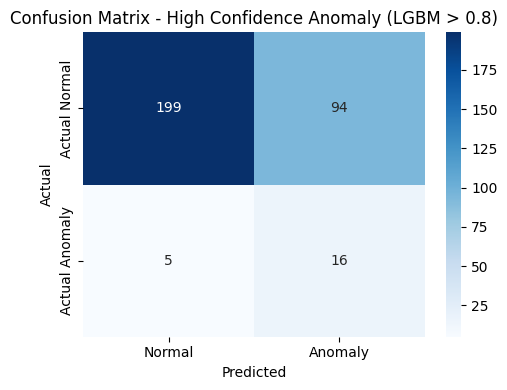

,precision,recall,f1-score,support
0,0.975,0.679,0.801,293.000
1,0.145,0.762,0.244,21.000
accuracy,0.685,0.685,0.685,0.685
macro avg,0.560,0.721,0.523,314.000
weighted avg,0.920,0.685,0.764,314.000


In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 假設你已經有 X_train_proc, y_train, X_test_proc, y_test

# 訓練 LGBM 模型
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_train_proc, y_train)
lgbm_scores = lgbm.predict_proba(X_test_proc)[:, 1]

# ➤ 策略：高可信異常才保留
pred_final = np.zeros_like(lgbm_scores, dtype=bool)
pred_final[lgbm_scores > 0.8] = True  # 高可信異常
# 其餘 score ≤ 0.8 全部視為正常

# 評估與混淆矩陣
report = classification_report(y_test, pred_final, output_dict=True)
conf_matrix = confusion_matrix(y_test, pred_final)

# 混淆矩陣圖
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Confusion Matrix - High Confidence Anomaly (LGBM > 0.8)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 顯示報告
pd.DataFrame(report).T.round(3)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


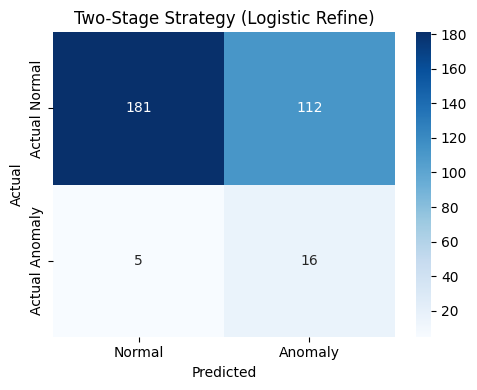

✅ 兩階段預測策略評估報告


,precision,recall,f1-score,support
0,0.973,0.618,0.756,293.000
1,0.125,0.762,0.215,21.000
accuracy,0.627,0.627,0.627,0.627
macro avg,0.549,0.690,0.485,314.000
weighted avg,0.916,0.627,0.720,314.000


In [81]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ⬇️ 第一階段 LGBM 主模型
model = LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_proc, y_train)
score_stage1 = model.predict_proba(X_test_proc)[:, 1]

# 🎯 建立中段區範圍 (0.5 ~ 0.85)
mask_intermediate = (score_stage1 >= 0.5) & (score_stage1 < 0.85)
mask_high = score_stage1 >= 0.85

# 🟢 第一階段預測（高信心）
final_pred = np.zeros_like(score_stage1, dtype=bool)
final_pred[mask_high] = True

# 🟡 第二階段：針對中段區段使用 Logistic Regression 精判
X_middle = X_test_proc[mask_intermediate]
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_proc, y_train)
score_middle = lr.predict_proba(X_middle)[:, 1]

# ➕ 中段區段判斷（使用 threshold = 0.5）
final_pred[mask_intermediate] = score_middle > 0.5

# 📊 評估
y_true = y_test
conf_matrix = confusion_matrix(y_true, final_pred)
report = classification_report(y_true, final_pred, output_dict=True)
df_report = pd.DataFrame(report).T.round(3)

# 🔍 視覺化
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Two-Stage Strategy (Logistic Refine)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 📋 顯示結果
print("✅ 兩階段預測策略評估報告")
display(df_report)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/314 [00:00<?, ?it/s]/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/User

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


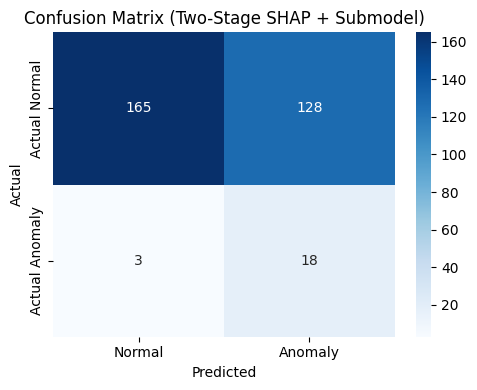

✅ Two-Stage SHAP 精判策略完成


,precision,recall,f1-score,support
0,0.982,0.563,0.716,293.000
1,0.123,0.857,0.216,21.000
accuracy,0.583,0.583,0.583,0.583
macro avg,0.553,0.710,0.466,314.000
weighted avg,0.925,0.583,0.682,314.000


In [85]:
import shap
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 假設已有 X_train_proc, y_train, X_test_proc, y_test
model = LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_proc, y_train)
score_stage1 = model.predict_proba(X_test_proc)[:, 1]

# ⬇️ SHAP 分析（使用 CPU KernelExplainer）
predict_fn = lambda x: model.predict_proba(x)[:, 1]
X_sample = shap.sample(X_train_proc, 100, random_state=42)
explainer = shap.KernelExplainer(predict_fn, X_sample)
shap_values = explainer.shap_values(X_test_proc, nsamples=100)
shap_sum = np.abs(shap_values).sum(axis=1)

# ➤ 建立 DataFrame
df = pd.DataFrame({
    "true_label": y_test,
    "score_stage1": score_stage1,
    "shap_sum": shap_sum
})
df["pred_stage1"] = (df["score_stage1"] > 0.5).astype(int)

# ➤ 中間區段判斷
mask_middle = (df["score_stage1"] > 0.4) & (df["score_stage1"] < 0.6)
X_sub = X_test_proc[mask_middle]
y_sub = df.loc[mask_middle, "true_label"]

# ➤ 訓練子模型
sub_model = LGBMClassifier(class_weight='balanced', random_state=42)
sub_model.fit(X_train_proc, y_train)
pred_sub = sub_model.predict(X_sub)

# ➤ 整合預測
df["final_pred"] = df["pred_stage1"]
df.loc[mask_middle, "final_pred"] = pred_sub

# 🧼 確保預測為 int 型別
df["final_pred"] = df["final_pred"].astype(int)

# 混淆矩陣與報告
cm = confusion_matrix(df["true_label"], df["final_pred"])
report = classification_report(df["true_label"], df["final_pred"], output_dict=True)
df_report = pd.DataFrame(report).T.round(3)

# 可視化
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Confusion Matrix (Two-Stage SHAP + Submodel)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("✅ Two-Stage SHAP 精判策略完成")
display(df_report)

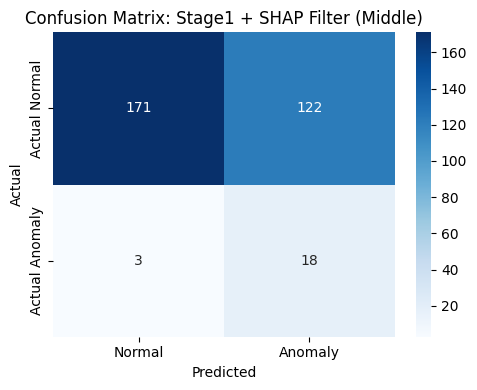

,precision,recall,f1-score,support
0,0.983,0.584,0.732,293.000
1,0.129,0.857,0.224,21.000
accuracy,0.602,0.602,0.602,0.602
macro avg,0.556,0.720,0.478,314.000
weighted avg,0.926,0.602,0.698,314.000


In [86]:
# 初步 LGBM 預測（門檻 = 0.5）
df["pred_stage1"] = (df["score_stage1"] > 0.5).astype(int)

# 中段模糊區（score 0.4 ~ 0.6）
mask_middle = (df["score_stage1"] > 0.4) & (df["score_stage1"] < 0.6)

# 改為：中段樣本以 SHAP sum 決定異常與否（例如 SHAP_sum > 0.5 判異常）
df["final_pred"] = df["pred_stage1"]
df.loc[mask_middle, "final_pred"] = (df.loc[mask_middle, "shap_sum"] > 0.5).astype(int)

# 評估與可視化
cm = confusion_matrix(df["true_label"], df["final_pred"])
report = classification_report(df["true_label"], df["final_pred"], output_dict=True)
df_report = pd.DataFrame(report).T.round(3)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Confusion Matrix: Stage1 + SHAP Filter (Middle)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

display(df_report)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/314 [00:00<?, ?it/s]/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/User

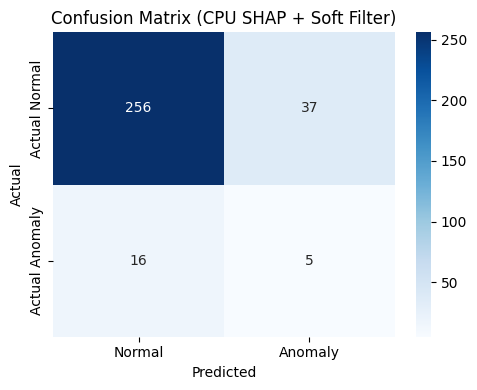

,precision,recall,f1-score,support
0,0.941,0.874,0.906,293.000
1,0.119,0.238,0.159,21.000
accuracy,0.831,0.831,0.831,0.831
macro avg,0.530,0.556,0.532,314.000
weighted avg,0.886,0.831,0.856,314.000


In [88]:
import shap
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 訓練主模型（LGBM）
model = LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_proc, y_train)
score_stage1 = model.predict_proba(X_test_proc)[:, 1]

# 使用 shap.KernelExplainer + lambda 包裝 (CPU-only)
predict_fn = lambda x: model.predict_proba(x)[:, 1]
X_sample = shap.sample(X_train_proc, 100, random_state=42)

# 注意：KernelExplainer 較慢，不建議用太多樣本
explainer = shap.KernelExplainer(predict_fn, X_sample)
shap_values = explainer.shap_values(X_test_proc, nsamples=100)

# SHAP sum 異常貢獻度
shap_sum = np.abs(shap_values).sum(axis=1)

# Step 1：初步判斷（LGBM 閾值 > 0.5）
df = pd.DataFrame({
    "true_label": y_test,
    "score_stage1": score_stage1,
    "shap_sum": shap_sum
})
df["pred_stage1"] = (df["score_stage1"] > 0.5).astype(int)

# Step 2：中間模糊區段（0.4 ~ 0.6） → SHAP 判斷
# 稍微留住一些 SHAP 篩選邏輯，但不刪掉高信心區
mask_middle = (df["score_stage1"] > 0.45) & (df["score_stage1"] < 0.7)
df["final_pred"] = (df["score_stage1"] > 0.5).astype(int)
df.loc[mask_middle, "final_pred"] = (df.loc[mask_middle, "shap_sum"] > 0.25).astype(int)

# Step 3：高分但 SHAP 低的可疑異常 → 視為正常
mask_high_fp = (df["score_stage1"] > 0.85) & (df["shap_sum"] < 0.3)
df.loc[mask_high_fp, "final_pred"] = 0

# 分析與視覺化
cm = confusion_matrix(df["true_label"], df["final_pred"])
report = classification_report(df["true_label"], df["final_pred"], output_dict=True)
df_report = pd.DataFrame(report).T.round(3)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Confusion Matrix (CPU SHAP + Soft Filter)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

display(df_report)

[LightGBM] [Info] Number of positive: 1170, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70596
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 279
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:13:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Threshold = 0.807
              precision  recall  f1-score  support
0                 0.976   0.696     0.813  293.000
1                 0.152   0.762     0.254   21.000
accuracy          0.701   0.701     0.701    0.701
macro avg         0.564   0.729     0.533  314.000
weighted avg      0.921   0.701     0.775  314.000


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ValueError: x and y must have same first dimension, but have shapes (314,) and (315,)

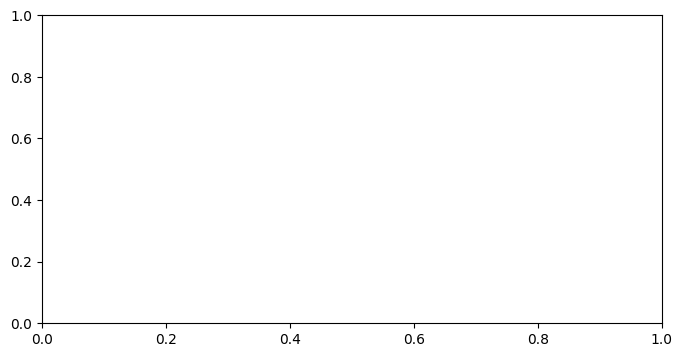

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

# 假設你已有前處理後資料：
# X_train_proc, y_train, X_test_proc, y_test

# 1️⃣ 建立與訓練模型
model_lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
model_xgb = XGBClassifier(scale_pos_weight=5, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

model_lgbm.fit(X_train_proc, y_train)
model_xgb.fit(X_train_proc, y_train)
model_rf.fit(X_train_proc, y_train)

# 2️⃣ 預測機率
score_lgbm = model_lgbm.predict_proba(X_test_proc)[:, 1]
score_xgb = model_xgb.predict_proba(X_test_proc)[:, 1]
score_rf = model_rf.predict_proba(X_test_proc)[:, 1]

# 3️⃣ 結合分數（加權平均，可調整權重）
final_score = (
    score_lgbm * 0.4 +
    score_xgb * 0.3 +
    score_rf * 0.3
)

# 4️⃣ 找最佳 threshold（以 F1-score 最大為準）
precision, recall, thresholds = precision_recall_curve(y_test, final_score)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
thresholds = thresholds[:len(f1_scores)]
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

# 5️⃣ 預測與評估
final_pred = final_score > best_thresh
report = classification_report(y_test, final_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, final_pred)
df_report = pd.DataFrame(report).T.round(3)

# 6️⃣ 顯示結果與圖表
print(f"✅ Best Threshold = {best_thresh:.3f}")
print(df_report)

# F1-score 曲線
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, color="green", label="F1-score")
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best Threshold = {best_thresh:.3f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Threshold (LGBM + XGB + RF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 混淆矩陣圖
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()